## Setup
Configure notebook and download index files

In [1]:
# To have time runtime for cells
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 468 µs (started: 2022-02-09 23:26:47 +00:00)


In [2]:
#Download Index file which contains the object_id which are required to download the IRS files
!irsx_index --year=2021 --verbose

Getting index file for year: 2021 remote=https://s3.amazonaws.com/irs-form-990/index_2021.csv local=/opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv
Beginning streaming download of https://s3.amazonaws.com/irs-form-990/index_2021.csv
Total file size: 55.76 MB
Download completed to /opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv in 0:00:01.413513
time: 2.13 s (started: 2022-02-09 23:26:47 +00:00)


In [3]:
!irsx --file temp --verbose 202012339349300801

Processing filing 202012339349300801
Printing result to file temp
File already available at /opt/conda/miniconda3/lib/python3.8/site-packages/irsx/XML/202012339349300801_public.xml -- skipping
Filing 202012339349300801 is version 2019v5.1
In 202012339349300801 keyerrors: [{'schedule_name': 'IRS990', 'group_keyerrors': [], 'keyerrors': [{'element_path': '/IRS990/DonorRstrOrQuasiEndowmentsInd'}, {'element_path': '/IRS990/BusinessRlnWith35CtrlEntInd'}, {'element_path': '/IRS990/OrganizationFollowsFASB117Ind'}, {'element_path': '/IRS990/NoDonorRestrictionNetAssetsGrp/BOYAmt'}, {'element_path': '/IRS990/NoDonorRestrictionNetAssetsGrp/EOYAmt'}]}]


time: 644 ms (started: 2022-02-09 23:26:50 +00:00)


## Transformation
Runterladen der einzelnen XML Files mit Spark, auslesen der wichtigen Daten und schreiben in ein Dateiformat, welches besser für die Analyse geeignet ist.   

In [4]:
#Set path of index file, and amount of lines to be read (amount of IRS files later processed)
path = "/opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv"
nrows = 1000

time: 809 µs (started: 2022-02-09 23:26:50 +00:00)


In [5]:
#Have a look at the index file to get an idea, we need the last column (zoom out to see whole file)
!head -5 {path} | column -t -s,  

RETURN_ID  FILING_TYPE  EIN        TAX_PERIOD  SUB_DATE               TAXPAYER_NAME                                        RETURN_TYPE  DLN             OBJECT_ID
17606342   EFILE        452772761  201906      1/21/2021 10:02:51 AM  CAMDENS CHARTER SCHOOL NETWORK INC                   990          93493065013010  202010659349301301  
17606343   EFILE        237061115  201906      1/21/2021 10:02:51 AM  JACKSON STATE UNIVERSITY DEVELOPMENT FOUNDATION INC  990          93493072000410  202010729349300041  
17606347   EFILE        344427516  201904      1/21/2021 10:02:52 AM  TIFFIN UNIVERSITY                                    990          93493072000210  202010729349300021  
17606350   EFILE        840865247  201912      1/21/2021 10:03:29 AM  NETWORK MINISTRIES INC                               990          93493072008360  202010729349300836  
time: 157 ms (started: 2022-02-09 23:26:50 +00:00)


In [6]:
# Read indexfile as PandasDF, extract object_ids and convert to PysparkDF
import pandas as pd
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType

spark = SparkSession.builder.getOrCreate()

df21 = pd.read_csv(path, index_col=False, dtype=str, nrows= nrows) # read all as string, not beautiful but we only need object id anyways

sdf = spark.createDataFrame(df21["OBJECT_ID"], StringType())

time: 2.79 s (started: 2022-02-09 23:26:50 +00:00)


In [7]:
#Define custom transformation which downloads the IRS files via IRSX, transforms it into a python dict and extracts the required fields
from irsx.xmlrunner import XMLRunner
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
from pyspark.sql.functions import udf

xml_runner = XMLRunner()
def transform_data(object_id):
    try: #Download files with basic error handling
        filing = xml_runner.run_filing(object_id)
        schedules = filing.list_schedules()
    except: 
        print(f"Transform error for id {object_id}")
        return ["", "", "", "", 0, 0, 0, 0, 0, 0, 0, 0]
    
    
    # Initialize with values to avoid NANs 
    ein, state, name = "", "", ""
    state, name, revenue, revenueEZ, vol_cnt, empl_cnt, rvn_ls_exp, liab_eoy, liab_boy,assts_eoy, assts_boy = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    #For different IRS forms the data is in different places, get the required 
    if "ReturnHeader990x" in schedules:
        header = filing.get_parsed_sked("ReturnHeader990x")
        header_part_i = header[0]["schedule_parts"]["returnheader990x_part_i"]
        ein = header_part_i["ein"]
        state = header_part_i.get("USAddrss_SttAbbrvtnCd", "XX")
        name = header_part_i["BsnssNm_BsnssNmLn1Txt"]
        
    if "IRS990EZ" in schedules:
        irs990ez = filing.get_parsed_sked("IRS990EZ")
        irs990ez_part_i = irs990ez[0]["schedule_parts"].get("ez_part_i", None)
        if irs990ez_part_i:
            revenueEZ = irs990ez_part_i.get("TtlRvnAmt", 0)        
    
    if "IRS990" in schedules:
        irs990 = filing.get_parsed_sked("IRS990")
        irs990_part_i = irs990[0]["schedule_parts"]["part_i"]
        revenue = irs990_part_i["CYTtlRvnAmt"]
        vol_cnt = int(irs990_part_i.get("TtlVlntrsCnt", 0))
        empl_cnt = int(irs990_part_i.get("TtlEmplyCnt", 0))
        rvn_ls_exp = int(irs990_part_i.get("CYRvnsLssExpnssAmt", 0))
        liab_eoy = int(irs990_part_i.get("TtlLbltsEOYAmt", 0))
        liab_boy = int(irs990_part_i.get("TtlLbltsBOYAmt", 0))
        assts_eoy = int(irs990_part_i.get("TtlAsstsEOYAmt", 0))
        assts_boy = int(irs990_part_i.get("TtlAsstsBOYAmt", 0))



    
    revenue = int(revenue) + int(revenueEZ) #Sum the two rev values because we want to only return one
    return [object_id, ein, state, name, revenue, vol_cnt, empl_cnt, rvn_ls_exp, liab_eoy, liab_boy,assts_eoy, assts_boy ]
     
#Define PySpark Schema    
my_schema = StructType([
    StructField("ObjectID", StringType(), nullable=False),
    StructField("EIN", StringType(), nullable=False),
    StructField("State", StringType(), nullable=False),
    StructField("Name", StringType(), nullable=False),
    StructField("Revenue", IntegerType(), nullable=False),
    StructField("TtlVlntrsCnt", IntegerType(), nullable=False),
    StructField("TtlEmplyCnt", IntegerType(), nullable=False),
    StructField("CYRvnsLssExpnssAmt", IntegerType(), nullable=False),
    StructField("TtlLbltsEOYAmt", IntegerType(), nullable=False),
    StructField("TtlLbltsBOYAmt", IntegerType(), nullable=False),
    StructField("TtlAsstsEOYAmt", IntegerType(), nullable=False),
    StructField("TtlAsstsBOYAmt", IntegerType(), nullable=False),
])

spark_transform_data = udf(lambda z: transform_data(z), my_schema)

time: 39.1 ms (started: 2022-02-09 23:26:53 +00:00)


In [8]:
#Basic example of what the function return
transform_data("202021359349301552")

['202021359349301552',
 '541965765',
 'VA',
 'PARK PLACE SCHOOL INC',
 671334,
 56,
 19,
 -14709,
 6015,
 14414,
 725910,
 750315]

time: 65.9 ms (started: 2022-02-09 23:26:53 +00:00)


In [ ]:
# Apply the transformation function and write the result as csv and parquet to HDFS
anz = sdf.count()
print(anz)
sdf2 = sdf.withColumn('valuelist', spark_transform_data('value')).select("valuelist.*")
sdf2.explain()
sdf2.write.mode('overwrite').csv(f"hdfs://big-spark-cluster-m/user/root/{anz}ps.csv")
sdf2.write.mode('overwrite').save(f"hdfs://big-spark-cluster-m/user/root/{anz}ps.parquet")

10000
== Physical Plan ==
*(2) Project [pythonUDF0#36.ObjectID AS ObjectID#12, pythonUDF0#36.EIN AS EIN#13, pythonUDF0#36.State AS State#14, pythonUDF0#36.Name AS Name#15, pythonUDF0#36.Revenue AS Revenue#16, pythonUDF0#36.TtlVlntrsCnt AS TtlVlntrsCnt#17, pythonUDF0#36.TtlEmplyCnt AS TtlEmplyCnt#18, pythonUDF0#36.CYRvnsLssExpnssAmt AS CYRvnsLssExpnssAmt#19, pythonUDF0#36.TtlLbltsEOYAmt AS TtlLbltsEOYAmt#20, pythonUDF0#36.TtlLbltsBOYAmt AS TtlLbltsBOYAmt#21, pythonUDF0#36.TtlAsstsEOYAmt AS TtlAsstsEOYAmt#22, pythonUDF0#36.TtlAsstsBOYAmt AS TtlAsstsBOYAmt#23]
+- BatchEvalPython [<lambda>(value#0)], [pythonUDF0#36]
   +- *(1) Scan ExistingRDD[value#0]




### Zeiten von erfolgreichen Läufen (u.a. aufgrund von Caching nicht sinnvoll vergleichbar)

|Anzahl | Zeit| Kommentar |  
-------|--------|---------------
|4710 | time: 2min 44s (started: 2022-01-17 18:46:15 +00:00) | erster Versuch (zusätzlicher Zeitbedarf für Sampling  & lokal)|
|46099| time: 12min 22s (started: 2022-01-17 20:42:31 +00:00) | erster Versuch mit ErrorHandling (zusätzlicher Zeitbedarf für Sampling & lokal)|
|184781| time: 1h 14min 7s (started: 2022-01-25 12:37:15 +00:00) | -  (zusätzlicher Zeitbedarf für Sampling & lokal)|
|184781| time: 14min 23s (started: 2022-02-02 11:34:34 +00:00) | mehr Attribute, dafür kein Samplen mehr sonder direkt beim Einlesen, speichern in HDFS|

## Aggregation
In diesem Schritt wird das gerade erzeugte File wieder eingelesen, um Analysen zu ermöglichen.  
Hier ist die Verwendung von Pyspark nicht mehr zwangsläufig erforderlich, wird aber für unser einfaches Beispiel trotzdem verwendet.  
Wenn Pyspark verwendet wird, sollte das File auf HDFS liegen, damit alle Worker Zugriff darauf haben.

In [3]:
#Einlesen des Files von HDFS als PysparkDF
from pyspark.sql.session import SparkSession
spark2 = SparkSession.builder.appName("Test1").getOrCreate()

hdfs_path = "hdfs://big-spark-cluster-m/user/root/184781.parquet"
df = spark2.read.parquet(hdfs_path, header=True, inferSchema=True)

type(df), df.printSchema(), df.head(5)

root
 |-- ObjectID: string (nullable = true)
 |-- EIN: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Revenue: integer (nullable = true)
 |-- TtlVlntrsCnt: integer (nullable = true)
 |-- TtlEmplyCnt: integer (nullable = true)
 |-- CYRvnsLssExpnssAmt: integer (nullable = true)
 |-- TtlLbltsEOYAmt: integer (nullable = true)
 |-- TtlLbltsBOYAmt: integer (nullable = true)
 |-- TtlAsstsEOYAmt: integer (nullable = true)
 |-- TtlAsstsBOYAmt: integer (nullable = true)



(pyspark.sql.dataframe.DataFrame,
 None,
 [Row(ObjectID='202010659349301301', EIN='452772761', State='NJ', Name="CAMDEN'S CHARTER SCHOOL", Revenue=5148336, TtlVlntrsCnt=0, TtlEmplyCnt=6, CYRvnsLssExpnssAmt=1302111, TtlLbltsEOYAmt=15896401, TtlLbltsBOYAmt=17300598, TtlAsstsEOYAmt=24491485, TtlAsstsBOYAmt=24842081),
  Row(ObjectID='202010729349300041', EIN='237061115', State='MS', Name='JACKSON STATE UNIVERSITY', Revenue=10386900, TtlVlntrsCnt=0, TtlEmplyCnt=0, CYRvnsLssExpnssAmt=3123744, TtlLbltsEOYAmt=22864113, TtlLbltsBOYAmt=20379310, TtlAsstsEOYAmt=60511849, TtlAsstsBOYAmt=54569751),
  Row(ObjectID='202010729349300021', EIN='344427516', State='OH', Name='TIFFIN UNIVERSITY', Revenue=64789812, TtlVlntrsCnt=16, TtlEmplyCnt=1194, CYRvnsLssExpnssAmt=995667, TtlLbltsEOYAmt=28335011, TtlLbltsBOYAmt=30287043, TtlAsstsEOYAmt=84770678, TtlAsstsBOYAmt=85702921),
  Row(ObjectID='202010729349300836', EIN='840865247', State='CO', Name='NETWORK MINISTRIES INC', Revenue=218029, TtlVlntrsCnt=0, TtlEm

In [4]:
# Umwandlung in RDD und dann Aufsummierung der Revenues staatenweise
from operator import add

two_col_df = df.select("State", "Revenue") #Reduzierung auf die notwendigen Spalten 
two_col_df.printSchema()
rdd = two_col_df.rdd #Umwandlung in ein Key, Value RDD

reduced_rdd = rdd.reduceByKey(add).sortBy(lambda x: x[1], ascending = False) #Aggreation und Sortierung nach Rev
state_rev = reduced_rdd.collectAsMap() #Umwandlung in Python Dict
state_rev

root
 |-- State: string (nullable = true)
 |-- Revenue: integer (nullable = true)



{'CA': 106408523167,
 'NY': 91528335932,
 'PA': 67741481219,
 'TX': 46584829555,
 'MO': 35258367904,
 'IL': 34193375787,
 'FL': 33918087515,
 'OH': 32432309967,
 'MD': 30846109123,
 'MA': 30763181332,
 'WI': 26739476181,
 'WA': 25497047400,
 'NC': 25155248409,
 'VA': 25149568077,
 'GA': 24111079151,
 'NJ': 21603531779,
 'DC': 21366864744,
 'MN': 21050609165,
 'TN': 20017954834,
 'IN': 19655247991,
 'MI': 17576295804,
 'CT': 12753735805,
 'IA': 12581959378,
 'KY': 12194589121,
 'OR': 11416409055,
 'AZ': 9392140979,
 'CO': 8787348925,
 'OK': 8484476755,
 'NE': 8057950606,
 'NH': 7383333727,
 'AR': 7023177618,
 'DE': 6852814220,
 'AL': 6401678075,
 'LA': 6359008465,
 'HI': 6264205796,
 'KS': 5548599753,
 'SC': 5306331753,
 'WV': 5238848159,
 'RI': 5102848789,
 'ME': 4094556969,
 'MT': 3909882954,
 'NM': 3322449390,
 'SD': 3174786870,
 'ND': 3016922247,
 'XX': 2812601645,
 'VT': 2811351956,
 'MS': 2591830358,
 'UT': 2466648085,
 'NV': 2259523194,
 'AK': 1763358153,
 'ID': 1514337329,
 'WY'

### Plot

In [ ]:
#!pip install cartopy

/tmp/ipykernel_2453/2602625185.py:17: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_visible(False)
/tmp/ipykernel_2453/2602625185.py:18: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


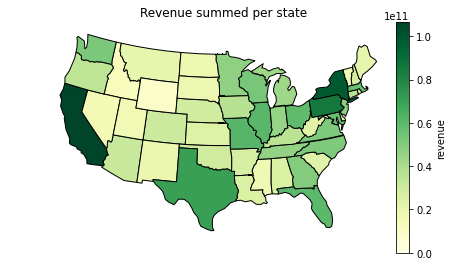

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import numpy as np

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

ax.set_title('Revenue summed per state')

cmap = cm.get_cmap("YlGn")
min_val = min(state_rev.values())
max_val = max(state_rev.values())

for astate in shpreader.Reader(states_shp).records():

    edgecolor = 'black'

    try: #Set values of the states depending on the values from our data
        rev_one_state = state_rev[ astate.attributes['postal'] ]
    except:
        rev_one_state = 0

    # Add shape with corresponding color
    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=cmap(np.sqrt((rev_one_state-min_val)/(max_val-min_val)))[:3], edgecolor=edgecolor)

# Plot Colorbarlegend
ax_c = fig.add_axes([0.9, 0.1, 0.03, 0.8])
norm = Normalize(vmin=min_val, vmax=max_val)
cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                  label='revenue')


plt.show()